In [1]:
import torch
from transformers import  BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

# Load the dataset into a pandas dataframe.
df = pd.read_csv('tweets_clean.csv', header=0)
reviews = df['text']
sentiment = df['category']
sentiment = pd.DataFrame(list(map(lambda x: 0 if x=="M" else (1 if x=="N" else 2), sentiment)))


# Split dataset
X_train, X_val, y_train, y_val = train_test_split(reviews, 
sentiment, stratify=sentiment, test_size=0.2, random_state=42)

# Report datasets lenghts
print('Training set length : {}'.format(len(X_train)))
print('Validation set length : {}'.format(len(X_val)))


# Tokenization

tokenizer = BertTokenizer.from_pretrained("/home/jupyter/pytorch/",
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=115,
                   truncation=True,pad_to_max_length=True)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

Training set length : 4032
Validation set length : 1009


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Max n°tokens in a sentence: 80


In [2]:
sentiment

,0
0,1
1,0
2,2
3,0
4,2
...,...
5036,2
5037,0
5038,2
5039,2


In [2]:
# Data loaders
batch_size = 32

y_train_labels = torch.tensor(y_train.values)

y_val_labels = torch.tensor(y_val.values)


def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks,
                   y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)

In [3]:
from transformers import BertModel
import torch

# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)
set_seed(42)

# Create model
model = BertForSequenceClassification.from_pretrained(
        "/home/jupyter/pytorch/", num_labels=3, output_attentions=False,
         output_hidden_states=False)

# Fine-tune model
#nn.Sequential(
        #nn.Linear(model.fc.in_features, 1000),
        #nn.Linear(1000, 128),
        #nn.Linear(128, 64),
        #nn.Linear(64, 8)
    #)

model.softmax = torch.nn.Softmax(3)




Some weights of the model checkpoint at /home/jupyter/pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [7]:
# Optimizer

optimizer = AdamW(model.parameters(),
                  lr = 4e-5,
                  eps = 1e-6
                  )

if run_on == 'cuda':
    model.cuda()

# Define number of epochs
epochs = 10

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = total_steps)

In [8]:
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [9]:
#function to train the model
def training(n_epochs, training_dataloader,
             validation_dataloader):
    # ========================================
    #               Training 
    # ========================================
    print('======= Training =======')
    for epoch_i in range(0,n_epochs):
        # Perform one full pass over the training set
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_loss = 0
        # Put the model into training mode.
        model.train()
        # For each batch of training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Clear any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass 
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # pull loss value out of the output tuple
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass 
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Update parameters
            # ¿take a step using the computed gradient
            optimizer.step()
            scheduler.step()

            print('batch loss: {0} | avg loss: {1}'.format(
                  batch_loss, total_loss/(step+1)))
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)


        print("")
        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, 
        # measure accuracy on the validation set.

        print("")
        print("======= Validation =======")

        t0 = time.time()

        # Put the model in evaluation mode
        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evaluate data for one epoch
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # Model will not to compute gradients
            with torch.no_grad():
                # Forward pass 
                # This will return the logits 
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # The "logits" are the output values 
            # prior to applying an activation function 
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Save batch logits and labels 
            # We will use thoses in the confusion matrix
            predict_labels = np.argmax(
                             logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calculate the accuracy for this batch
            tmp_eval_accuracy = flat_accuracy(
                                logits, b_labels)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy

        # Report the final accuracy for this validation run.
        print("  Accuracy: {0:.2f}".
              format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
             format_time(time.time() - t0)))

    #print the confusion matrix"
    conf = confusion_matrix(
           all_labels, all_logits, normalize='true')
    print(conf)
    print("")
    print("Training complete")

#call function to train the model
training(epochs, train_dataloader, val_dataloader)

======= Training =======

======= Epoch 1 / 10 =======
batch loss: 0.949037492275238 | avg loss: 0.949037492275238
batch loss: 0.9402865171432495 | avg loss: 0.9446620047092438
batch loss: 0.8370596170425415 | avg loss: 0.9087945421536764
batch loss: 1.062182068824768 | avg loss: 0.9471414238214493
batch loss: 1.0722718238830566 | avg loss: 0.9721675038337707
batch loss: 1.0196813344955444 | avg loss: 0.980086475610733
batch loss: 1.0485737323760986 | avg loss: 0.9898703694343567
batch loss: 0.9936376214027405 | avg loss: 0.9903412759304047
batch loss: 0.9918193817138672 | avg loss: 0.9905055099063449
batch loss: 1.040952205657959 | avg loss: 0.9955501794815064
batch loss: 1.0775227546691895 | avg loss: 1.0030022317712957
batch loss: 1.0637165307998657 | avg loss: 1.0080617566903431
batch loss: 1.020261526107788 | avg loss: 1.0090002004916852
batch loss: 1.1152516603469849 | avg loss: 1.0165895904813493
batch loss: 1.1550445556640625 | avg loss: 1.0258199214935302
batch loss: 1.0106092

NameError: name 'plt' is not defined

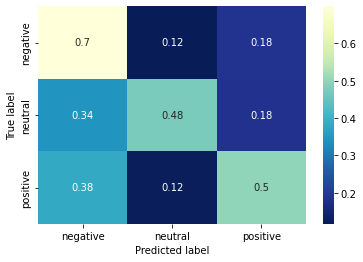

In [11]:
import seaborn as sns
#plot the confusion matrix
conf = [[0.6991342,  0.11688312, 0.18398268],
 [0.34313725, 0.4754902,  0.18137255],
 [0.3819242,  0.11953353, 0.49854227]]
ticks = ['negative', 'neutral', 'positive']
ax = sns.heatmap(conf, annot=True, xticklabels=ticks, yticklabels=ticks, cmap='YlGnBu_r')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

In [22]:
from transformers import BertModel
import torch

model.softmax = torch.nn.Softmax(3)


In [4]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
nn.Sequential(
        nn.Linear(model.fc.in_features, 1000),
        nn.Linear(1000, 128),
        nn.Linear(128, 64),
        nn.Linear(64, 8)
    )


In [49]:
from torchsummary import summary

summary(model,input_size=(768,1,1)) 

ValueError: too many values to unpack (expected 2)

In [ ]:
torch.